In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import catboost as cb
from tqdm.notebook import tqdm

# from xgboost import plot_importance, plot_tree

# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import random

plt.style.use('default')

In [2]:
!nvidia-smi

Thu Apr 25 02:36:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti      On | 00000000:65:00.0 Off |                  N/A |
|  0%   37C    P8               11W / 285W|     70MiB / 12282MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Functions

In [3]:
def ts_array_create(dirname, dir_list, time_seq):
    
    columns = ['RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
               'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2']
    
    def reamin_HO_time(y_train):
        def f(L):    
            for i, e in enumerate(L):
                if e: return i+1
            return 0

        out = []
        for a2 in y_train:
            a1_out = []
            for a1 in a2:
                a1_out.append(a1.any())
      
            out.append(f(a1_out))
        return out
    
    def HO(y_train):
        out = []
        for a2 in y_train:
            if sum(a2.reshape(-1)) == 0: ho = 0
            elif sum(a2.reshape(-1)) > 0: ho = 1
            out.append(ho)
        return out

    split_time = []
    for i, f in enumerate(tqdm(dir_list)):
    
        f = os.path.join(dirname, f)
        df = pd.read_csv(f)

        
        # preprocess data with ffill method
        del df['Timestamp'], df['lat'], df['long'], df['gpsspeed']
        # df[columns] = df[columns].replace(0, np.nan)
        # df[columns] = df[columns].fillna(method='ffill')
        # df.dropna(inplace=True)
        
        df.replace(np.nan,0,inplace=True); df.replace('-',0,inplace=True)
        
        X = df[features]
        Y = df[target]

        Xt_list = []
        Yt_list = []

        for j in range(time_seq):
            X_t = X.shift(periods=-j)
            Xt_list.append(X_t)
    
        for j in range(time_seq,time_seq+predict_t):
            Y_t = Y.shift(periods=-(j))
            Yt_list.append(Y_t)

        # YY = Y.shift(periods=-(0))

        X_ts = np.array(Xt_list); X_ts = np.transpose(X_ts, (1,0,2)); X_ts = X_ts[:-(time_seq+predict_t-1),:,:]
        Y_ts = np.array(Yt_list); Y_ts = np.transpose(Y_ts, (1,0,2)); Y_ts = Y_ts[:-(time_seq+predict_t-1),:,:]
        split_time.append(len(X_ts))

        if i == 0:
            X_final = X_ts
            Y_final = Y_ts
        else:
            X_final = np.concatenate((X_final,X_ts), axis=0)
            Y_final = np.concatenate((Y_final,Y_ts), axis=0)

    split_time = [(sum(split_time[:i]), sum(split_time[:i])+x) for i, x in enumerate(split_time)]
    
    return X_final, np.array(HO(Y_final)), np.array(reamin_HO_time(Y_final)), split_time # forecast HO


In [4]:
def days_in_file(file, dates):
    
    for date in dates:
        if date in file: return True 
    return False

def train_valid_split(L, valid_size=0.2):
    
    length = len(L)
    v_num = int(length*valid_size)
    v_files = random.sample(L, v_num)
    t_files = list(set(L) - set(v_files))
    
    return t_files, v_files

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    print(f"Random seed set as {seed}")

# Load Data

In [5]:
# Time sequence length and prediction time length
seed = 55688
time_seq = 20
predict_t = 2
valid_ratio = 0.2
task = 'classification'

In [6]:
# Setup seed
set_seed(seed)

# Get GPU
device_count = torch.cuda.device_count()
num_of_gpus = device_count

for i in range(device_count):
    print("GPU {}: {}".format(i, torch.cuda.get_device_name(i)))
    gpu_id = i

# Save best model to 
save_path = "../model"

# Define DataSet
dirname = "../data/single"
# dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not 'sm' in f) ) ] # Take out cell phone data

# train_dates = ['03-26', '04-01']
# test_dates = ['04-10']
    
# train_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, train_dates) )]
# test_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, test_dates) )]

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)
# train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f] # Add cell phone data.

# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2' ]
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2']

num_of_features = len(features)

# target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

# Data
print('Loading training data...')
X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
cond = y_train2 > 0
X_train_fore = X_train_2d[cond]
y_train2_fore = y_train2[cond]


print('Loading testing data...')
X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
cond = y_test2 > 0
X_test_fore = X_test_2d[cond]
y_test2_fore = y_test2[cond]


Random seed set as 55688
GPU 0: NVIDIA GeForce RTX 4070 Ti
GPU 1: NVIDIA GeForce RTX 4070 Ti
Loading training data...


  0%|          | 0/136 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/33 [00:00<?, ?it/s]

# 特別任務處理

In [7]:
# Time sequence length and prediction time length
time_seq = 20
predict_t = 10
valid_ratio = 0.2

# Define DataSet
dirname = "../data/single"
# dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not '08-21' in f) ) ] # Take out cell phone data

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)
# train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f] # Add cell phone data.

# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2' ]
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2']

num_of_features = len(features)

target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
# target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

# Data
print('Loading training data...')
X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
cond = y_train2 > 0
X_train_fore = X_train_2d[cond]
y_train2_fore = y_train2[cond]


print('Loading testing data...')
X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
cond = y_test2 > 0
X_test_fore = X_test_2d[cond]
y_test2_fore = y_test2[cond]


Loading training data...


  0%|          | 0/296 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

In [8]:
L = []
record_file = '../info/2023-09-09-record.csv'

f = open(record_file, 'w')
f.write(','.join([ 'num','roc_auc', 'aucpr', 'p', 'r', 'f1']) + '\n')

for i, l in enumerate(train_dir_list):
    
    L.append(l)
    
    features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
    
    num_of_features = len(features)
    
    target = ['LTE_HO', 'MN_HO'] # For eNB HO.
    # target = ['eNB_to_ENDC'] # Setup gNB
    # target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
    # target = ['RLF'] # For RLF
    # target = ['SCG_RLF'] # For scg failure
    # target = ['dl-loss'] # For DL loss
    # target = ['ul-loss'] # For UL loss
    
    
    # Data
    print('Loading training data...')
    X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, L, time_seq)
    X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
    cond = y_train2 > 0
    X_train_fore = X_train_2d[cond]
    y_train2_fore = y_train2[cond]


    print('Loading testing data...')
    X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
    X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
    cond = y_test2 > 0
    X_test_fore = X_test_2d[cond]
    y_test2_fore = y_test2[cond]
    
    model = cb.CatBoostClassifier(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                              colsample_bylevel=0.8, scale_pos_weight=1,
                              loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed) 
    
    model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)
    # 選擇最佳迭代次數
    best_iteration = model.best_iteration_

    # 使用最佳迭代次數重新訓練模型
    model = cb.CatBoostClassifier(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                                colsample_bylevel=0.8, scale_pos_weight=1,
                                loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed)
    model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)
    
    preds = model.predict_proba(X_test_2d)[:, 1]
    
    # PR and AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test1, preds)
    
    p = precision_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds]) 
    r = recall_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds])
    f1 = f1_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds])
    
    aucpr = auc(recall, precision)
    
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test1, preds)
    roc_auc = auc(fpr, tpr)
    
    print(i, roc_auc, aucpr, p, r, f1)
    write_list = [ i+1, roc_auc, aucpr, p, r, f1]
    write_list = [str(s) for s in write_list]
    f.write(','.join(write_list) + '\n')
    

f.close()


Loading training data...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

0 0.5426419681774726 0.4565309302898344 0.44685447251245425 0.8971499380421314 0.5965686707277597
Loading training data...


  0%|          | 0/2 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

1 0.5797406660540257 0.4958021078402774 0.47514988513475653 0.7505753230660294 0.5819179962257677
Loading training data...


  0%|          | 0/3 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

2 0.6233199761932573 0.5430351848423509 0.5089491525423728 0.6644538856434767 0.5763974201474201
Loading training data...


  0%|          | 0/4 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

3 0.6321956741698687 0.5461079431648662 0.51250805931657 0.7035758541334749 0.5930319307669353
Loading training data...


  0%|          | 0/5 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

4 0.6162915625425383 0.5274016788098085 0.5035175879396985 0.6651619755708975 0.5731609655645807
Loading training data...


  0%|          | 0/6 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

5 0.5982694280744603 0.5054211479051802 0.5028521628901917 0.5617808461674633 0.530685618729097
Loading training data...


  0%|          | 0/7 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

6 0.6373131132759156 0.554427584693548 0.536517797179315 0.5656753407682775 0.5507109004739337
Loading training data...


  0%|          | 0/8 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

7 0.6473485151520251 0.5763609160577423 0.5462539570875835 0.5498318286422376 0.5480370533745037
Loading training data...


  0%|          | 0/9 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

8 0.6523304569651415 0.5783921919172991 0.5440216930768579 0.5682421667551779 0.5558682194034373
Loading training data...


  0%|          | 0/10 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

9 0.6607026240620253 0.5898136947129229 0.554070265638389 0.5723136838378474 0.5630442354580285
Loading training data...


  0%|          | 0/11 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

10 0.6749322337858727 0.6003518087295315 0.5617892342683851 0.5902814657461498 0.575683024731322
Loading training data...


  0%|          | 0/12 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

11 0.6974664465694685 0.6238824700428359 0.586927641484368 0.5865639936271907 0.586745761211209
Loading training data...


  0%|          | 0/13 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

12 0.697074503096893 0.6196393251538023 0.5840007198776208 0.5744379536201097 0.5791798670295837
Loading training data...


  0%|          | 0/14 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

13 0.7061006130137406 0.6218815430529328 0.596387142477641 0.5961232076473713 0.5962551458545439
Loading training data...


  0%|          | 0/15 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

14 0.7046517751729441 0.6259566547047284 0.6016431027894535 0.5574437953620109 0.5787007259027842
Loading training data...


  0%|          | 0/16 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

15 0.6978057436297842 0.6176881867757402 0.5835457501977674 0.5876261285183219 0.5855788313120176
Loading training data...


  0%|          | 0/17 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

16 0.7042994512445986 0.6234185966921988 0.5988309352517985 0.5893963533368738 0.5940761887768757
Loading training data...


  0%|          | 0/18 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

17 0.7047775774984905 0.6190171113315237 0.5992311818344359 0.593290847937688 0.5962462195338908
Loading training data...


  0%|          | 0/19 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

18 0.7140331329917156 0.6454518791096804 0.6119145675701562 0.5654983182864224 0.5877915267491605
Loading training data...


  0%|          | 0/20 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

19 0.717647241751408 0.6429093279824738 0.6083947919511973 0.5914321118782085 0.5997935460706432
Loading training data...


  0%|          | 0/21 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

20 0.7420474409770326 0.6771715924783246 0.6378526794167771 0.5963002301292264 0.6163769441903019
Loading training data...


  0%|          | 0/22 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

21 0.7410576104142148 0.6687921558271643 0.6401677628443427 0.5944414940697469 0.6164578457019597
Loading training data...


  0%|          | 0/23 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

22 0.7349454217999822 0.6656270592340536 0.6480981085013511 0.5519560984244999 0.5961759082217973
Loading training data...


  0%|          | 0/24 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

23 0.7559626699449473 0.6924322798280796 0.6513890188008605 0.6163922818197911 0.6334076128973578
Loading training data...


  0%|          | 0/25 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

24 0.7834017739670284 0.7204613876488517 0.6688128417710355 0.6711807399539742 0.6699946987100195
Loading training data...


  0%|          | 0/26 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

25 0.7757249260005411 0.7129531482970636 0.6637668161434978 0.6550716941051513 0.6593905915894511
Loading training data...


  0%|          | 0/27 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

26 0.7688595372758811 0.7070443164837498 0.658129073717066 0.6345370862099486 0.6461177955026812
Loading training data...


  0%|          | 0/28 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

27 0.785849693680121 0.7293976636828193 0.6772342169991801 0.6579925650557621 0.6674747474747474
Loading training data...


  0%|          | 0/29 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

28 0.7718159365897681 0.7109655581591074 0.6622226280704958 0.6418835192069393 0.6518944671670637
Loading training data...


  0%|          | 0/30 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

29 0.7897603386197227 0.7301716604432195 0.680817898404548 0.6571959638874137 0.6687984147000541
Loading training data...


  0%|          | 0/31 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

30 0.7899650882318853 0.7339929145838888 0.6834653004191895 0.6494069746857851 0.6660009985022466
Loading training data...


  0%|          | 0/32 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

31 0.7773614460232035 0.7189807825856076 0.6753283567986393 0.6325898389095415 0.6532608198894018
Loading training data...


  0%|          | 0/33 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

32 0.7676989013970246 0.7029654538423465 0.6736118134924649 0.5894848645778014 0.628746754779325
Loading training data...


  0%|          | 0/34 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

33 0.7886500921551909 0.7335623425831153 0.6822394552676376 0.6385200920516906 0.659656181419166
Loading training data...


  0%|          | 0/35 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

34 0.7902016859310075 0.7357053413703992 0.6851625058878945 0.6437422552664188 0.6638068726326838
Loading training data...


  0%|          | 0/36 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

35 0.7935681502074885 0.7390638855048391 0.6882491741387446 0.6454239688440432 0.6661489973964281
Loading training data...


  0%|          | 0/37 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

36 0.7917186207939398 0.7383425474860709 0.6802128245115127 0.6563108514781377 0.6680481102752376
Loading training data...


  0%|          | 0/38 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

37 0.7874473206855934 0.7335064793767656 0.6812341742473975 0.6429456540980705 0.6615363599107509
Loading training data...


  0%|          | 0/39 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

38 0.7949174836195247 0.739394499748578 0.6922136543163439 0.6515312444680474 0.6712566113441547
Loading training data...


  0%|          | 0/40 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

39 0.7983118298599445 0.7476207055278121 0.7012569424144987 0.6370154009559214 0.6675942674272993
Loading training data...


  0%|          | 0/41 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

40 0.8098636455242654 0.7613488982761456 0.7135855714565772 0.644361833952912 0.6772093023255814
Loading training data...


  0%|          | 0/42 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

41 0.803970338068634 0.7540789144675685 0.7016450890684318 0.6379890246061249 0.6683046683046683
Loading training data...


  0%|          | 0/43 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

42 0.7967045257525072 0.7441949138430173 0.697308075772682 0.6190476190476191 0.6558514628657164
Loading training data...


  0%|          | 0/44 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

43 0.8065375392293337 0.7546896761897249 0.7021111756730583 0.6417064967250841 0.67055123936367
Loading training data...


  0%|          | 0/45 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

44 0.8070932490428573 0.7567817336563242 0.7150180940892642 0.6295804567180032 0.6695848630330415
Loading training data...


  0%|          | 0/46 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

45 0.7915082376196487 0.7326165949931674 0.7018805878121468 0.604531775535493 0.6495791525987922
Loading training data...


  0%|          | 0/47 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

46 0.8023055132671162 0.7518166460830144 0.7012248897599216 0.6333864400778899 0.6655815467609171
Loading training data...


  0%|          | 0/48 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

47 0.8139825655187147 0.7648494216449656 0.7245159307448007 0.6259514958399717 0.6716368298589677
Loading training data...


  0%|          | 0/49 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

48 0.8115796071101367 0.7603850636370112 0.7247343196499271 0.6156841918923703 0.6657733537519143
Loading training data...


  0%|          | 0/50 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

49 0.8142253922939325 0.7666551744982669 0.7207143577842801 0.6322357939458311 0.6735819699184309
Loading training data...


  0%|          | 0/51 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

50 0.81686861676767 0.7683147418919327 0.7225485316077651 0.6424145866525048 0.6801293164035047
Loading training data...


  0%|          | 0/52 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

51 0.8052220310106275 0.7524947615218593 0.7148257893123531 0.6192246415294742 0.6635997154375148
Loading training data...


  0%|          | 0/53 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

52 0.8039367808565889 0.7529187347929854 0.7134083930399181 0.6169233492653567 0.6616669831023353
Loading training data...


  0%|          | 0/54 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

53 0.8147444422676423 0.7680760637879209 0.7238489499192245 0.6345370862099486 0.6762569568908594
Loading training data...


  0%|          | 0/55 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

54 0.8165008452070183 0.7681613705090435 0.7173891865562592 0.6517967781908303 0.6830218429717572
Loading training data...


  0%|          | 0/56 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

55 0.8227986555247908 0.7753117033975311 0.7251720747295969 0.6527704018410339 0.6870691261412335
Loading training data...


  0%|          | 0/57 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

56 0.8207890936428681 0.7738009570192963 0.7279564571994063 0.6510886882634095 0.6873802737933935
Loading training data...


  0%|          | 0/58 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

57 0.8212427978689698 0.7728157190586027 0.7265285996055226 0.6520623119136131 0.6872842615915664
Loading training data...


  0%|          | 0/59 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

58 0.8225490398903483 0.7719385196614541 0.7273894154818326 0.6520623119136131 0.687669186969103
Loading training data...


  0%|          | 0/60 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

59 0.8219062242488594 0.7730522313944992 0.7253095591877167 0.6480793060718711 0.6845229748048427
Loading training data...


  0%|          | 0/61 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

60 0.8229773514008937 0.7758580264582806 0.7243878550440744 0.6546291379005134 0.6877440952203832
Loading training data...


  0%|          | 0/62 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

61 0.8213229004526823 0.7717261997803893 0.7228915662650602 0.6425916091343601 0.6803804882620308
Loading training data...


  0%|          | 0/63 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

62 0.8196472313418238 0.7709596322714615 0.7264837905236907 0.6446273676756948 0.6831121324391503
Loading training data...


  0%|          | 0/64 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

63 0.8248708059246541 0.7751408981582047 0.7305 0.6465746149761019 0.6859799042163583
Loading training data...


  0%|          | 0/65 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

64 0.8200224944681814 0.7713988092108689 0.726866116688202 0.6472827049035228 0.6847698862306287
Loading training data...


  0%|          | 0/66 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

65 0.8255516927740585 0.7767451728539694 0.7313698359359557 0.6549831828642237 0.691072095629436
Loading training data...


  0%|          | 0/67 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

66 0.8317911665436156 0.7884008988427451 0.7358007677921056 0.6616215259337936 0.6967423218530083
Loading training data...


  0%|          | 0/68 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

67 0.8328032127549754 0.7885965605985998 0.736774701999803 0.661975570897504 0.6973751690055481
Loading training data...


  0%|          | 0/69 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

68 0.8289966874773786 0.7825422565791618 0.7320564715174253 0.6563108514781377 0.692117421944276
Loading training data...


  0%|          | 0/70 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

69 0.8221276958932178 0.772650413110061 0.7257245294293397 0.6449814126394052 0.6829748348095037
Loading training data...


  0%|          | 0/71 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

70 0.8354832578572977 0.7876369618451843 0.7425296365239541 0.6708266949902638 0.7048593350383632
Loading training data...


  0%|          | 0/72 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

71 0.8348660433612538 0.7890200474073383 0.7441077441077442 0.6650734643299699 0.7023742755655262
Loading training data...


  0%|          | 0/73 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

72 0.8231636222146577 0.7750800835536162 0.7320540862994631 0.6517082669499027 0.6895486046076044
Loading training data...


  0%|          | 0/74 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

73 0.8354555188167109 0.7908160068471802 0.739898496974429 0.671003717472119 0.7037690308206461
Loading training data...


  0%|          | 0/75 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

74 0.8320162291371954 0.7868736627216735 0.7401247401247402 0.6617100371747212 0.6987242394504416
Loading training data...


  0%|          | 0/76 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

75 0.8360215965284012 0.7890775806842732 0.7400548696844993 0.6685254027261462 0.7024739583333334
Loading training data...


  0%|          | 0/77 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

76 0.8241981907642525 0.775495464451127 0.7366144975288303 0.6332094175960347 0.6810090433127083
Loading training data...


  0%|          | 0/78 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

77 0.8362232554230747 0.7925536893895171 0.7448227797690163 0.6621525933793592 0.7010589448036735
Loading training data...


  0%|          | 0/79 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

78 0.8309967449563868 0.7844057622759419 0.747570829497801 0.6469286599398124 0.6936180308422302
Loading training data...


  0%|          | 0/80 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

79 0.8331719311828347 0.7876152580219384 0.7413143148242486 0.6440077889892016 0.6892435939942215
Loading training data...


  0%|          | 0/81 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

80 0.829779466766551 0.7846614874778087 0.7440763155195405 0.6420605416887945 0.6893143915997529
Loading training data...


  0%|          | 0/82 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

81 0.8389471958599106 0.7954804391275927 0.7490486681353895 0.6620640821384316 0.7028753993610224
Loading training data...


  0%|          | 0/83 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

82 0.840447218126178 0.7958889904008191 0.7487382483918852 0.669676048858205 0.7070036910713451
Loading training data...


  0%|          | 0/84 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

83 0.8310959992692806 0.7862139629478262 0.7415662650602409 0.6537440254912373 0.6948913350268134
Loading training data...


  0%|          | 0/85 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

84 0.836497138251676 0.795281825508394 0.7464200477326969 0.6643653744025492 0.7030064624894633
Loading training data...


  0%|          | 0/86 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

85 0.8358062944087419 0.7915652910601542 0.7455919395465995 0.6549831828642237 0.6973566413796353
Loading training data...


  0%|          | 0/87 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

86 0.8376859449187456 0.7916031623608837 0.7423929098966027 0.6672862453531598 0.7028387638092575
Loading training data...


  0%|          | 0/88 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

87 0.8336750749784837 0.7895975714346734 0.7414261289349291 0.652504868118251 0.6941292782825668
Loading training data...


  0%|          | 0/89 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

88 0.8378440836527044 0.7945288528662501 0.748804780876494 0.6654275092936803 0.7046583559846283
Loading training data...


  0%|          | 0/90 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

89 0.8302698308324665 0.7845497135402362 0.7412320369812079 0.6528589130819614 0.6942444350322368
Loading training data...


  0%|          | 0/91 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

90 0.8397219595310861 0.7964430548622918 0.7467862481315396 0.6633032395114179 0.7025734777105892
Loading training data...


  0%|          | 0/92 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

91 0.8371642449078821 0.7929641640379296 0.7485421274884375 0.6589661887059657 0.7009037845980042
Loading training data...


  0%|          | 0/93 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

92 0.8344026441677678 0.7886277976438005 0.7450090744101633 0.6540095592140202 0.6965497737556561
Loading training data...


  0%|          | 0/94 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

93 0.8422454737871603 0.798981555209603 0.7510712506228201 0.6671092228713047 0.7066047906998547
Loading training data...


  0%|          | 0/95 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

94 0.8396377955421181 0.7965788948594069 0.7521050521251003 0.6640998406797664 0.7053680549026982
Loading training data...


  0%|          | 0/96 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

95 0.8398473092660175 0.798735386311801 0.7523885350318471 0.6691449814126395 0.708329429401293
Loading training data...


  0%|          | 0/97 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

96 0.8338395202053541 0.7884094549785434 0.7451841501147819 0.6608249247654452 0.700473800253319
Loading training data...


  0%|          | 0/98 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

97 0.8429086679166028 0.8001993016953567 0.7523979036883219 0.6734820322180917 0.7107561533791042
Loading training data...


  0%|          | 0/99 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

98 0.8425893711928718 0.7984029463881701 0.7526242820360467 0.6726854310497433 0.7104131613385679
Loading training data...


  0%|          | 0/100 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/74 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
f.close()

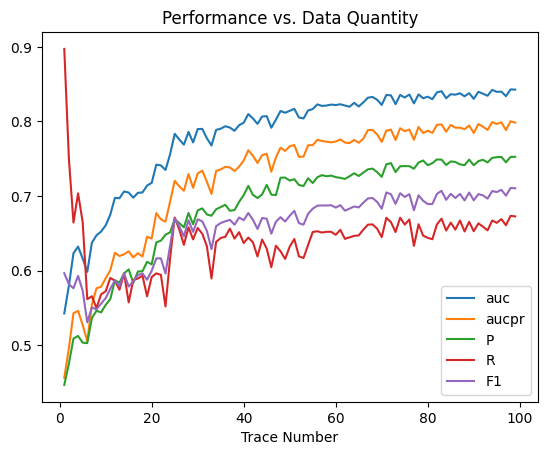

In [10]:
file = '../info/2023-09-09-record.csv'
df = pd.read_csv(file)

x = df['num']
y1 = df['roc_auc']
y2 = df['aucpr']
y3 = df['p']
y4 = df['r']
y5 = df['f1']

plt.plot(x, y1, label = 'auc')
plt.plot(x, y2, label = 'aucpr')
plt.plot(x, y3, label = 'P')
plt.plot(x, y4, label = 'R')
plt.plot(x, y5, label = 'F1')

plt.title('Performance vs. Data Quantity')
plt.xlabel('Trace Number')

plt.legend()
plt.show()

In [ ]:
# L = []
# record_file = '../info/2023-09-09-record2.csv'

# f = open(record_file, 'w')
# f.write(','.join([ 'num', 'rmse', 'mae']) + '\n')

# for i, l in enumerate(train_dir_list):
    
#     L.append(l)
    
#     features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
    
#     num_of_features = len(features)
    
#     target = ['LTE_HO', 'MN_HO'] # For eNB HO.
#     # target = ['eNB_to_ENDC'] # Setup gNB
#     # target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
#     # target = ['RLF'] # For RLF
#     # target = ['SCG_RLF'] # For scg failure
#     # target = ['dl-loss'] # For DL loss
#     # target = ['ul-loss'] # For UL loss
    
    
#     # Data
#     print('Loading training data...')
#     X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, L, time_seq)
#     X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
#     cond = y_train2 > 0
#     X_train_fore = X_train_2d[cond]
#     y_train2_fore = y_train2[cond]


#     print('Loading testing data...')
#     X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
#     X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
#     cond = y_test2 > 0
#     X_test_fore = X_test_2d[cond]
#     y_test2_fore = y_test2[cond]
    
    
#     model = cb.CatBoostRegressor(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,colsample_bylevel=0.8,
#                               loss_function='RMSE', eval_metric = 'RMSE', early_stopping_rounds=10, random_seed=seed) 
#     model.fit(X_train_fore, y_train2_fore, eval_set=(X_test_fore, y_test2_fore), verbose=False)
#     best_iteration = model.best_iteration_
#     model = cb.CatBoostRegressor(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,colsample_bylevel=0.8,
#                                 loss_function='RMSE', eval_metric = 'RMSE', early_stopping_rounds=10, random_seed=seed) 
#     model.fit(X_train_fore, y_train2_fore, eval_set=(X_test_fore, y_test2_fore), verbose=False)

    
#     preds = model.predict(X_test_fore)    
    
#     rmse = mean_squared_error(y_test2_fore, preds, squared=False)
#     mae = mean_absolute_error(y_test2_fore, preds)
    
#     print(rmse, mae)
    
#     write_list = [ i+1, rmse, mae]
#     write_list = [str(s) for s in write_list]
#     f.write(','.join(write_list) + '\n')
    

# f.close()


In [11]:
f.close()

In [12]:
file = '../info/2023-09-09-record2.csv'
df = pd.read_csv(file)

x = df['num']
y1 = df['rmse']
y2 = df['mae']

plt.plot(x, y1, label = 'rmse')
plt.plot(x, y2, label = 'mae')

plt.title('Performance vs. Data Quantity')
plt.xlabel('Trace Number')

plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../info/2023-09-09-record2.csv'

In [ ]:
# Validate with other route data.

In [13]:
# Time sequence length and prediction time length
time_seq = 20
predict_t = 10
valid_ratio = 0.2

# Define DataSet
dirname = "../data/single"
# dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and '08-21' in f) ] # Take out cell phone data

train_dir_list = ['2023-08-21_sm01_#02_LTE.csv',
  '2023-08-21_sm00_#04_All.csv',
  '2023-08-21_sm00_#03_All.csv',
  '2023-08-21_sm00_#05_All.csv',
  '2023-08-21_sm01_#04_LTE.csv',
  '2023-08-21_sm00_#02_All.csv',
  '2023-08-21_sm01_#01_LTE.csv',
  '2023-08-21_sm01_#05_LTE.csv',
  '2023-08-21_sm00_#01_All.csv', '2023-08-21_sm01_#03_LTE.csv']

test_dir_list = ['2023-08-21_sm00_#06_All.csv', '2023-08-21_sm01_#06_LTE.csv']

# train_dir_list += [f for f in os.listdir(dirname) if 'sm' in f] # Add cell phone data.

# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2' ]
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2']

num_of_features = len(features)

target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
# target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

In [14]:
train_dir_list, test_dir_list

(['2023-08-21_sm01_#02_LTE.csv',
  '2023-08-21_sm00_#04_All.csv',
  '2023-08-21_sm00_#03_All.csv',
  '2023-08-21_sm00_#05_All.csv',
  '2023-08-21_sm01_#04_LTE.csv',
  '2023-08-21_sm00_#02_All.csv',
  '2023-08-21_sm01_#01_LTE.csv',
  '2023-08-21_sm01_#05_LTE.csv',
  '2023-08-21_sm00_#01_All.csv',
  '2023-08-21_sm01_#03_LTE.csv'],
 ['2023-08-21_sm00_#06_All.csv', '2023-08-21_sm01_#06_LTE.csv'])

In [15]:
L = []
record_file = '../info/2023-09-10-record.csv'

f = open(record_file, 'w')
f.write(','.join([ 'num','roc_auc', 'aucpr', 'p', 'r', 'f1']) + '\n')

for i, l in enumerate(train_dir_list):
    
    L.append(l)
    
    features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
    
    num_of_features = len(features)
    
    target = ['LTE_HO', 'MN_HO'] # For eNB HO.
    # target = ['eNB_to_ENDC'] # Setup gNB
    # target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
    # target = ['RLF'] # For RLF
    # target = ['SCG_RLF'] # For scg failure
    # target = ['dl-loss'] # For DL loss
    # target = ['ul-loss'] # For UL loss
    
    
    # Data
    print('Loading training data...')
    X_train, y_train1, y_train2, split_time_train = ts_array_create(dirname, L, time_seq)
    X_train_2d = X_train.reshape(-1, time_seq*num_of_features)
    cond = y_train2 > 0
    X_train_fore = X_train_2d[cond]
    y_train2_fore = y_train2[cond]


    print('Loading testing data...')
    X_test, y_test1, y_test2, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
    X_test_2d = X_test.reshape(-1, time_seq*num_of_features)
    cond = y_test2 > 0
    X_test_fore = X_test_2d[cond]
    y_test2_fore = y_test2[cond]
    
    model2 = cb.CatBoostClassifier(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                              colsample_bylevel=0.8, scale_pos_weight=1,
                              loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed) 
    
    model2.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False, init_model=model)
    # 選擇最佳迭代次數
    best_iteration = model2.best_iteration_

    # 使用最佳迭代次數重新訓練模型
    model2 = cb.CatBoostClassifier(iterations=best_iteration,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                                colsample_bylevel=0.8, scale_pos_weight=1,
                                loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed)
    model2.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False, init_model=model)
    
    preds = model2.predict_proba(X_test_2d)[:, 1]
    
    # PR and AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test1, preds)
    
    p = precision_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds]) 
    r = recall_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds])
    f1 = f1_score(y_test1, [1 if (p >= 0.5) else 0 for p in preds])
    
    aucpr = auc(recall, precision)
    
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test1, preds)
    roc_auc = auc(fpr, tpr)
    
    print(i, roc_auc, aucpr, p, r, f1)
    write_list = [ i+1, roc_auc, aucpr, p, r, f1]
    write_list = [str(s) for s in write_list]
    f.write(','.join(write_list) + '\n')
    

f.close()


Loading training data...


  0%|          | 0/1 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/2 [00:00<?, ?it/s]

CatBoostError: /src/catboost/catboost/private/libs/algo/apply.cpp:44: Empty tree range [0, 0)

In [16]:
file = '../info/2023-09-10-record.csv'
df = pd.read_csv(file)

x = df['num']
y1 = df['roc_auc']
y2 = df['aucpr']
y3 = df['p']
y4 = df['r']
y5 = df['f1']

plt.plot(x, y1, label = 'auc')
plt.plot(x, y2, label = 'aucpr')
plt.plot(x, y3, label = 'P')
plt.plot(x, y4, label = 'R')
plt.plot(x, y5, label = 'F1')

plt.title('Performance vs. Data Quantity')
plt.xlabel('Trace Number')

plt.legend()
plt.show()

EmptyDataError: No columns to parse from file

# Train

In [ ]:
model = cb.CatBoostClassifier(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                              colsample_bylevel=0.8, scale_pos_weight=1,
                              loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed) 

In [ ]:
model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)
# 選擇最佳迭代次數
best_iteration = model.best_iteration_

# 使用最佳迭代次數重新訓練模型
model = cb.CatBoostClassifier(iterations=best_iteration,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,
                              colsample_bylevel=0.8, scale_pos_weight=1,
                              loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed)
model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)

In [ ]:
preds = model.predict_proba(X_test_2d)[:, 1]

In [ ]:
# plot all data point on a plot
ths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]

if task == 'forecast':
    rmse = round(np.sqrt(np.mean((preds-y_test1)**2)), 2)
    mae = np.mean(np.abs(preds-np.array(y_test1)))
    print(f'RMSE is {rmse}. MAE is {mae}')
elif task == 'classification':
    # PR and AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test1, preds)
    aucpr = auc(recall, precision)
    
    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test1, preds)
    roc_auc = auc(fpr, tpr)
    
    # Manually count
    for threshold in ths:
        TP, FP, TN, FN = 0,0,0,0
        anses = np.where(preds<threshold, 0, 1)
        for ans, y in zip(anses, y_test1):
            if ans == y:
                if ans == 1: TP += 1
                elif ans == 0: TN +=1
            elif ans != y:
                if ans == 1: FP += 1
                elif ans == 0: FN +=1
        acc=(TP+TN)/(TP+TN+FP+FN)*100
        try:
            p, r = round(TP/(TP+FP), 2), round(TP/(TP+FN), 2)
            f1 = round(2*(p*r)/(p+r), 2)
        except:
            p, r, f1 = 'DNF', 'DNF', 'DNF'
        s = f'th: {threshold}; Acc: {acc}; precision: {p}; recall:{r}; f1:{f1}'
        print(s)
    
    # 初始化閥值列表和 F1 Score 列表
    thresholds = []
    f1_scores = []

    # 循環遍歷閥值，計算 F1 Score
    for threshold in range(5, 101, 5):
        threshold /= 100
        y_pred_threshold = [1 if pred >= threshold else 0 for pred in preds]
        f1_scores.append(f1_score(y_test1, y_pred_threshold))
        thresholds.append(threshold)

    # 繪製閥值與 F1 Score 的關係圖
    plt.figure()
    plt.plot(thresholds, f1_scores, lw=2, label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('Threshold-F1 Score Relationship')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.plot(recall, precision, lw=2, label='PR Curve (AUCPR = %0.2f)' % aucpr)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    print(f'ROC Auc is {roc_auc}.')
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Save Model
model.save_model('../model/nr_HO_cls_cb')

In [ ]:
# visulized on many sample on validation data
sample_value = 2
# samples = random.sample(split_time_test, sample_value)
samples = [split_time_test[8], split_time_test[9]]

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

# y_test
# preds

for i in range(sample_value):
    true = [y_test1[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    # prediciton = [preds[i] for i in range(samples[i][0], samples[i][1])]
    prediciton = [1 if preds[i] > 0.5 else 0 for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton, label='pred')

plt.legend()
plt.show()

In [ ]:
A = [test_dir_list[split_time_test.index(s)] for s in samples]
A

In [ ]:
# Check whethet it do good on training data
sample_value = 2
samples = random.sample(split_time_train, sample_value)
preds_train = model.predict(X_train_2d)

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

for i in range(sample_value):
    true = [y_train1[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    prediciton = [preds_train[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton, label='pred')

plt.legend()
plt.show()

# grid search

In [ ]:
import itertools

iterations =  [100, 200, 300]
learning_rates = [0.1, 0.01, 0.001]
depths = [4, 6, 8, 10]
l2_leaf_regs = [0.1, 1, 10]
border_counts =  [5, 10, 20]
colsample_bylevels = [0.5, 0.8, 1]
scale_pos_weights = [1, 2, 5]

In [ ]:
f_out = 'lte_ho_cls_cb.csv'
f_out = open(f_out, 'w')
cols_out = ['iteration','learning_rate','depth', 'l2_leaf_reg', 'border_count','colsample_bylevel','scale_pos_weight','auc','aucpr', 'p', 'r', 'f1','acc']
f_out.write(','.join(cols_out)+'\n')

for itera, lr, dep, l2_leaf, bc, cbl, spw in itertools.product(iterations, learning_rates, depths, l2_leaf_regs, border_counts, colsample_bylevels, scale_pos_weights):
    
    print(itera, lr, dep, l2_leaf, bc, cbl, spw)
    model = cb.CatBoostClassifier(iterations=itera,  learning_rate = lr, depth = dep, l2_leaf_reg = l2_leaf, 
                                  border_count = bc, colsample_bylevel= cbl,scale_pos_weight = spw, 
                              loss_function='Logloss', eval_metric = 'F1', early_stopping_rounds=10, random_seed=seed)
    
    model.fit(X_train_2d, y_train1, eval_set=(X_test_2d, y_test1), verbose=False)
    
    preds = model.predict_proba(X_test_2d)[:, 1]
    
    # AUCPR
    precision, recall, thresholds = precision_recall_curve(y_test1, preds)
    aucpr = auc(recall, precision)

    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test1, preds)
    roc_auc = auc(fpr, tpr)
    threshold = 0.5

    p = precision_score(y_test1, [1 if pred > threshold else 0 for pred in preds])
    r = recall_score(y_test1, [1 if pred > threshold else 0 for pred in preds])
    f1 = f1_score(y_test1, [1 if pred > threshold else 0 for pred in preds])
    acc = accuracy_score(y_test1, [1 if pred > threshold else 0 for pred in preds])
    
    cols_out = [itera, lr, dep, l2_leaf, bc, cbl, spw, roc_auc, aucpr, p, r, f1, acc]
    cols_out = [str(n) for n in cols_out]
    f_out.write(','.join(cols_out)+'\n')
    
f_out.close()

In [ ]:
import pandas as pd
df = pd.read_csv('lte_ho_cls_cb.csv')
max_value = df['aucpr'].max()
max_index = df['aucpr'].idxmax()
print(df.iloc[max_index])
max_value = df['auc'].max()
max_index = df['auc'].idxmax()
print(df.iloc[max_index])


# Forecast

In [ ]:
model = cb.CatBoostRegressor(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,colsample_bylevel=0.8,
                              loss_function='RMSE', eval_metric = 'RMSE', early_stopping_rounds=10, random_seed=seed) 

In [ ]:
model.fit(X_train_fore, y_train2_fore, eval_set=(X_test_fore, y_test2_fore), verbose=False)
best_iteration = model.best_iteration_
model = cb.CatBoostRegressor(iterations=200,  learning_rate=0.1, depth=10, l2_leaf_reg=10, border_count=20,colsample_bylevel=0.8,
                              loss_function='RMSE', eval_metric = 'RMSE', early_stopping_rounds=10, random_seed=seed) 
model.fit(X_train_fore, y_train2_fore, eval_set=(X_test_fore, y_test2_fore), verbose=False)

In [ ]:
preds = model.predict(X_test_fore)

In [ ]:
rmse = mean_squared_error(y_test2_fore, preds, squared=False)
mae = mean_absolute_error(y_test2_fore, preds)
rmse, mae

In [ ]:
model.save_model('../model/nr_HO_fst_cb')

# Load Model

In [ ]:
model = cb.CatBoostClassifier()      # parameters not required.
model.load_model('../model/nr_HO_cls_cb')

In [ ]:
preds = model.predict_proba(X_test_2d)[:, 1]

In [ ]:
# plot all data point on a plot
ths = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]

# PR and AUCPR
precision, recall, thresholds = precision_recall_curve(y_test1, preds)
aucpr = auc(recall, precision)

# ROC & AUC
fpr, tpr, thresholds = roc_curve(y_test1, preds)
roc_auc = auc(fpr, tpr)

# Manually count
for threshold in ths:
    TP, FP, TN, FN = 0,0,0,0
    anses = np.where(preds<threshold, 0, 1)
    for ans, y in zip(anses, y_test1):
        if ans == y:
            if ans == 1: TP += 1
            elif ans == 0: TN +=1
        elif ans != y:
            if ans == 1: FP += 1
            elif ans == 0: FN +=1
    acc=(TP+TN)/(TP+TN+FP+FN)*100
    try:
        p, r = round(TP/(TP+FP), 2), round(TP/(TP+FN), 2)
        f1 = round(2*(p*r)/(p+r), 2)
    except:
        p, r, f1 = 'DNF', 'DNF', 'DNF'
    s = f'th: {threshold}; Acc: {acc}; precision: {p}; recall:{r}; f1:{f1}'
    print(s)

# 初始化閥值列表和 F1 Score 列表
thresholds = []
f1_scores = []

# 循環遍歷閥值，計算 F1 Score
for threshold in range(5, 101, 5):
    threshold /= 100
    y_pred_threshold = [1 if pred >= threshold else 0 for pred in preds]
    f1_scores.append(f1_score(y_test1, y_pred_threshold))
    thresholds.append(threshold)

print(f'roc_auc: {roc_auc}')
print(f'aucpr: {aucpr}')

In [ ]:
model = cb.CatBoostRegressor()     # parameters not required.
model.load_model('../model/nr_HO_fst_cb')

In [ ]:
preds = model.predict(X_test_fore)

In [ ]:
rmse = mean_squared_error(y_test2_fore, preds, squared=False)
mae = mean_absolute_error(y_test2_fore, preds)
rmse, mae

In [ ]:
preds